In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import seaborn as sns
import cartopy.crs as ccrs
import cartopy
import geopandas as gpd
import xarray as xr
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({'font.size': 16})
plt.rc('xtick', labelsize=14) # Set x-axis tick label size
plt.rc('ytick', labelsize=14) # Set y-axis tick label size

ERROR 1: PROJ: proj_create_from_database: Open of /dartfs-hpc/rc/home/0/f004260/.conda/envs/arg24/share/proj failed


In [2]:
root_dir = '/dartfs-hpc/rc/lab/C/CMIG'
project_dir = os.path.join(root_dir,'damages','county')

ppt_prods = ['chirps','cpc','imerg','prism']
tws_prods = ['grace-csr','grace-jpl','clsm-grace']

prod_comb = []
for p in ppt_prods:
    for t in tws_prods:
        prod_comb.append(f"{p}_{t}")

In [3]:
coef_dict = {p:pd.read_csv(os.path.join(project_dir,'data','processed','damage_func_coefs',p,'county_se','lag1.csv')).set_index("Coefficient") for p in prod_comb}
panel_dict = {p:xr.Dataset.from_dataframe(pd.read_csv(os.path.join(project_dir,'data','processed','panels',f'{p}_county_panel.csv')).set_index(['county','year'])[['p_exc_rxmon']]) for p in prod_comb}# coef_dir = os.path.join(project_dir,'data','processed','damage_func_coefs','imerg-rain_clsm-grace')

xmin = panel_dict['prism_clsm-grace']['p_exc_rxmon'].min().values
xmax = panel_dict['prism_clsm-grace']['p_exc_rxmon'].max().values
fp = np.linspace(xmin,xmax,100)
lag1_me0 = {p:lag1_coef.loc['p_exc_rxmon'].values.reshape(-1,1)+2*np.outer(lag1_coef.loc['p_exc_rxmon_sq'],fp) for p,lag1_coef in coef_dict.items()}
lag1_me1 = {p:lag1_me0[p] + lag1_coef.loc['p_exc_rxmon_lag1'].values.reshape(-1,1)+2*np.outer(lag1_coef.loc['p_exc_rxmon_sq_lag1'],fp) for p,lag1_coef in coef_dict.items()}

lag1_me0_all = np.concatenate(list(lag1_me0.values()),axis=0)
lag1_me1_all = np.concatenate(list(lag1_me1.values()),axis=0)

lag1_pred0 = {p:np.outer(lag1_coef.loc['p_exc_rxmon'],fp)+np.outer(lag1_coef.loc['p_exc_rxmon_sq'],np.power(fp,2)) for p,lag1_coef in coef_dict.items()}
lag1_pred1 = {p:lag1_pred0[p] + np.outer(lag1_coef.loc['p_exc_rxmon_lag1'],fp)+np.outer(lag1_coef.loc['p_exc_rxmon_sq_lag1'],np.power(fp,2)) for p,lag1_coef in coef_dict.items()}

lag1_pred0_all = np.concatenate(list(lag1_pred0.values()),axis=0)
lag1_pred1_all = np.concatenate(list(lag1_pred1.values()),axis=0)

In [4]:
sep_coef_dict = {p:pd.read_csv(os.path.join(project_dir,'data','processed','damage_func_coefs',p,'county_se','sep_lag1.csv')).set_index("Coefficient") for p in prod_comb}
ps = np.arange(0,1001,10)
ts = np.arange(0,1001,10)
sep_lag1_me0 = np.empty((len(sep_coef_dict),len(ps),len(ts),1000))
sep_lag1_me1 = np.empty((len(sep_coef_dict),len(ps),len(ts),1000))
for k,sep_lag1_coef in enumerate(sep_coef_dict.values()):
    for i,p in enumerate(ps):
        for j,t in enumerate(ts):
            sep_lag1_me0[k,i,j,:] = sep_lag1_coef.loc['rxmon_pexcmax']+2*p*sep_lag1_coef.loc['rxmon_pexcmax_sq']+t*sep_lag1_coef.loc['rxmon_pexcmax:tws_def_pre_pexcmax']#+2*p*t*sep_lag1_coef.loc['rxmon_pexcmax_sq:twsa_pre_pexcmax']
            sep_lag1_me1[k,i,j,:] = sep_lag1_coef.loc['rxmon_pexcmax_lag1']+2*p*sep_lag1_coef.loc['rxmon_pexcmax_sq_lag1']+t*sep_lag1_coef.loc['rxmon_pexcmax_lag1:tws_def_pre_pexcmax_lag1']#+2*p*t*sep_lag1_coef.loc['rxmon_pexcmax_sq:twsa_pre_pexcmax']

    print(k)



0
1
2
3
4
5
6
7
8
9
10
11


In [5]:
sep_lag1_me0_all = np.concatenate([sep_lag1_me0[i] for i in range(len(sep_coef_dict))],axis=-1)
ci_lo_me0 = np.quantile(sep_lag1_me0_all,0.025,axis=-1)
ci_hi_me0 = np.quantile(sep_lag1_me0_all,0.975,axis=-1)

In [6]:
gdf = gpd.read_file(os.path.join(project_dir,'data','interim','cnty_bnds_fixed'))
gdf_state = gdf.dissolve(by='state')

In [7]:
# panel_all = xr.concat(panel_dict.values(),dim='product')
# panel_all['product'] = list(panel_dict.keys())

# coef_all = xr.concat([xr.Dataset.from_dataframe(coef.transpose()) for coef in coef_dict.values()],dim='product')
# coef_all['product'] = panel_all['product']

# me_obs = coef_all['p_exc_rxmon']+2*panel_all['p_exc_rxmon']*coef_all['p_exc_rxmon_sq']
# me_obs = me_obs.clip(max=0)
# me_obs.name = 'me'


# me_tot = (me_obs<0).sum("year")
# me_tot.name = 'me_tot'
# me_tot_df = gdf.merge(me_tot.median(['product',"index"]).to_dataframe().reset_index(),on='county')

In [11]:
delta_gdp_tot_dict = {}
dmg_cnt_dict = {}
for p in ppt_prods:
    for t in tws_prods:
        # if p=='cpc' and t=='grace-jpl':
        #     continue
        with xr.open_dataset(os.path.join(project_dir,'data','processed','delta_gdp_decomposition',f'{p}_{t}.nc')) as dmg:
            dmg['delta_gdp_obs'] = dmg['pop']*dmg['delta_gdppc_obs']
            dmg = dmg.assign_coords(product=f'{p}_{t}')
            delta_gdp_tot_dict[f'{p}_{t}'] = dmg['delta_gdp_obs'].sum('county')
            dmg_cnt_dict[f'{p}_{t}'] = (dmg['delta_gdppc_obs']<0).sum('year')
            

            print(p,t)
delta_gdp_tot = xr.concat(delta_gdp_tot_dict.values(),dim='product')
dmg_cnt = xr.concat(dmg_cnt_dict.values(),dim='product')
dmg_cnt.name = 'dmg_cnt'
dmg_cnt_df = gdf.merge(dmg_cnt.median(['product',"index"]).to_dataframe().reset_index(),on='county')

chirps grace-csr
chirps grace-jpl
chirps clsm-grace
cpc grace-csr
cpc grace-jpl
cpc clsm-grace
imerg grace-csr
imerg grace-jpl
imerg clsm-grace
prism grace-csr
prism grace-jpl
prism clsm-grace


In [12]:
delta_gdp_tot = delta_gdp_tot.sel(year=slice(2003,2024))

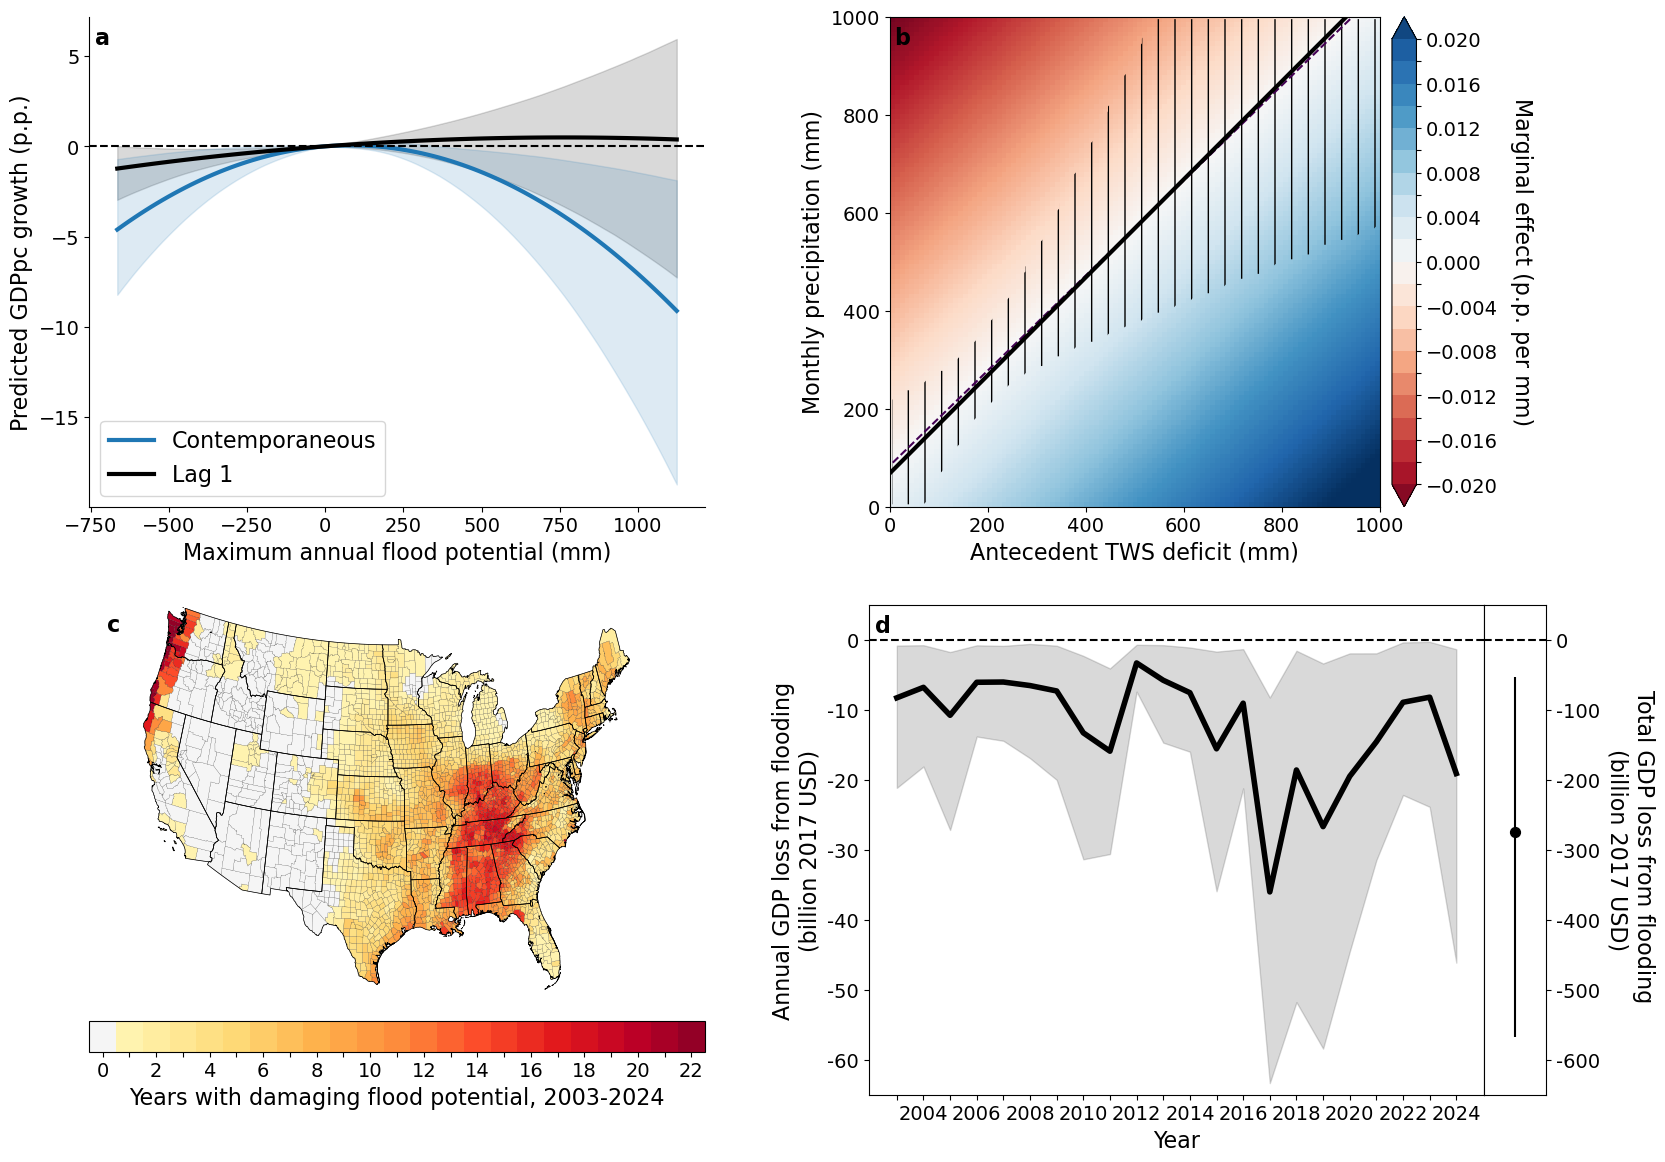

In [19]:
plt.rcParams.update({'font.size': 16})
plt.rc('xtick', labelsize=14) # Set x-axis tick label size
plt.rc('ytick', labelsize=14) # Set y-axis tick label size
fig = plt.figure(figsize=(18,14))
gs = gridspec.GridSpec(nrows=2,ncols=3,width_ratios=[1,0.0,1],wspace=0.2,figure=fig)
ax1 = plt.subplot(gs[0,0])
ax1.plot(fp,lag1_pred0_all.mean(axis=0),color='tab:blue',lw=3,label='Contemporaneous')
ax1.plot(fp,lag1_pred1_all.mean(axis=0),color='black',lw=3,label='Lag 1')
ax1.fill_between(fp,np.quantile(lag1_pred1_all,0.025,axis=0),np.quantile(lag1_pred1_all,0.975,axis=0),color='black',alpha=0.15)
ax1.fill_between(fp,np.quantile(lag1_pred0_all,0.025,axis=0),np.quantile(lag1_pred0_all,0.975,axis=0),color='tab:blue',alpha=0.15)
ax1.set_xlabel("Maximum annual flood potential (mm)")
ax1.set_ylabel("Predicted GDPpc growth (p.p.)")
ax1.axhline(0,color='black',linestyle='--')
ax1.legend(loc='lower left')

ax2 = plt.subplot(gs[0,2])
ax2.imshow(sep_lag1_me0_all.mean(axis=-1),origin='lower',extent=[0,1000,0,1000],cmap='RdBu',vmin=-0.02,vmax=0.02)
ax2.contour(sep_lag1_me0_all.mean(axis=-1),levels=[0],origin='lower',extent=[0,1000,0,1000],color='black',linestyles='--')
ax2.contourf((np.sign(ci_lo_me0)==np.sign(ci_hi_me0)).astype(int),levels=[-0.5,0.5],colors='none',hatches='||||',origin='lower',extent=[0,1000,0,1000])
ax2.set_xlabel("Antecedent TWS deficit (mm)")
ax2.set_ylabel("Monthly precipitation (mm)")
coef_all = pd.concat(coef_dict.values(),axis=1)
infl = (coef_all.loc['p_exc_rxmon']/2/-coef_all.loc['p_exc_rxmon_sq']).mean()

ax2.plot([0,1000-infl],[infl,1000],color='black',lw=3)

me_levels = np.linspace(-0.02,0.02,21)
me_cols = sns.color_palette("RdBu",len(me_levels)+1)
me_cmap = mpl.colors.ListedColormap(me_cols[1:-1])
me_cmap.set_under(me_cols[0])
me_cmap.set_over(me_cols[-1])
me_norm = plt.Normalize(vmin=me_levels[0],vmax=me_levels[-1])
me_cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=me_norm,cmap=me_cmap),ax=[ax2],orientation='vertical',ticks=me_levels,pad=0.02,extend='both',)
me_cbar.ax.set_ylabel('Marginal effect (p.p. per mm)',rotation=-90,labelpad=25)
for l in me_cbar.ax.get_yticklabels()[1::2]:
    l.set_visible(False)

ax3 = plt.subplot(gs[1,0],projection=ccrs.AlbersEqualArea(central_longitude=-96,central_latitude=37.5,standard_parallels=(29.5, 45.5)))
yr_levels = np.arange(-0.5,23.5,1)
yr_cols = sns.color_palette("YlOrRd",len(yr_levels)-1)
yr_cols[0] = 'whitesmoke'
yr_cmap = mpl.colors.ListedColormap(yr_cols)
# yr_cmap.set_under("whitesmoke")
yr_norm = plt.Normalize(vmin=-0.5,vmax=22.5)

dmg_cnt_df.plot(ax=ax3,column='dmg_cnt',transform=ccrs.PlateCarree(),cmap=yr_cmap,norm=yr_norm,edgecolor='black',lw=0.1)

yr_cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=yr_norm,cmap=yr_cmap),ax=[ax3],orientation='horizontal',ticks=yr_levels+0.5,pad=0.02,)
yr_cbar.ax.set_xlabel('Years with damaging flood potential, 2003-2024')
for l in yr_cbar.ax.get_xticklabels()[1::2]:
    l.set_visible(False)
    
dmg_levels = np.arange(-3e3,1,250)
dmg_cols = sns.color_palette("YlOrRd_r",len(dmg_levels))
dmg_cmap = mpl.colors.ListedColormap(dmg_cols[1:])
dmg_cmap.set_under(dmg_cols[0])
dmg_cmap.set_over('whitesmoke')
dmg_norm = plt.Normalize(vmin=-3e3,vmax=0)

for ax in [ax3,]:
    ax.set_extent([-123, -68, 24, 49],ccrs.PlateCarree())
    gdf_state.geometry.boundary.plot(ax=ax,transform=ccrs.PlateCarree(),edgecolor='black',lw=0.5)
    ax.set_frame_on(False)

ax4 = plt.subplot(gs[1,2])
yrs = np.arange(2003,2025)
ax4.plot(yrs,delta_gdp_tot.mean(['product','index']),color='black',lw=4)
ax4.fill_between(yrs,
                 delta_gdp_tot.quantile(0.025,['product','index']),
                 delta_gdp_tot.quantile(0.975,['product','index']),
                 color='black',alpha=0.15)
ax4.set_ylabel("Annual GDP loss from flooding\n(billion 2017 USD)")
ax4.set_yticks(np.arange(-6e10,1,1e10))
ax4.set_ylim(-6.5e10,5e9)
ax4.set_yticklabels(np.arange(-60,1,10))
ax4.set_xticks(yrs)
for l in ax4.get_xticklabels()[::2]:
    l.set_visible(False)
ax4.set_xlabel("Year")
ax4.axhline(0,color='black',linestyle='--')

ax4_ins = ax4.inset_axes([1,0,0.1,1])
ax4_ins.scatter([0],delta_gdp_tot.sum("year").mean(['product','index']),color='black',s=50)
ax4_ins.vlines([0],
               delta_gdp_tot.sum("year").quantile(0.025,['product','index']),
               delta_gdp_tot.sum("year").quantile(0.975,['product','index']),
               color='black')
ax4_ins.set_xticks([])
ax4_ins.yaxis.tick_right()
ax4_ins.yaxis.set_label_position("right")
ax4_ins.set_yticks(np.arange(-6e11,1,1e11))
ax4_ins.set_ylim(-6.5e11,5e10)
ax4_ins.set_yticklabels(np.arange(-600,1,100))
ax4_ins.set_ylabel("Total GDP loss from flooding \n(billion 2017 USD)",rotation=-90,labelpad=40)
ax4_ins.axhline(0,color='black',linestyle='--')

labels = ['a','b','c','d']
for i,ax in enumerate([ax1,ax2,ax3,ax4]):
    ax.text(0.01,0.98,labels[i],ha='left',va='top',fontsize=16,fontweight='bold',transform=ax.transAxes)
    if i in [0]:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
plt.savefig(os.path.join(project_dir,'figures','main','fig2_dmg_func.png'),bbox_inches='tight',dpi=350)
plt.savefig(os.path.join(project_dir,'figures','main','fig2_dmg_func.pdf'),bbox_inches='tight',dpi=350)
plt.show()


In [16]:
(coef_all.loc['p_exc_rxmon']/2/-coef_all.loc['p_exc_rxmon_sq']).mean()

np.float64(67.90418081462006)

In [17]:
(coef_all.loc['p_exc_rxmon']/2/-coef_all.loc['p_exc_rxmon_sq']).quantile([0.025,0.975])

0.025   -111.208066
0.975    181.433044
dtype: float64

In [20]:
for k,v in coef_dict.items():
    print(k,(v.loc['p_exc_rxmon']/-2/v.loc['p_exc_rxmon_sq']).mean())

chirps_grace-csr 78.18499335815156
chirps_grace-jpl 15.743109421760835
chirps_clsm-grace 107.59196742636712
cpc_grace-csr 93.84924182734764
cpc_grace-jpl 10.397368848329522
cpc_clsm-grace 102.92400841653713
imerg_grace-csr 47.09853163793379
imerg_grace-jpl -45.80687187531929
imerg_clsm-grace 70.13139892699209
prism_grace-csr 134.9836339182955
prism_grace-jpl 63.44175296955365
prism_clsm-grace 136.31103489949126


In [21]:
(me_tot_df['me_tot']>0).mean()


NameError: name 'me_tot_df' is not defined

In [63]:
gdf[gdf.county==36061]

,county,name,state,geometry
258,36061,New York County,NY,"POLYGON ((-73.93338 40.79719, -73.94642 40.777..."


In [58]:
cnty_ds.sel(year=2019)['delta_gdp'].mean(['index','product']).to_dataframe().sort_values('delta_gdp').head(20)

,year,delta_gdp
county,,
17031,2019,-1.218884e+09
48201,2019,-1.151941e+09
48113,2019,-9.407833e+08
47037,2019,-8.215454e+08
36061,2019,-7.128095e+08
40143,2019,-4.675862e+08
13121,2019,-4.028651e+08
47093,2019,-3.985219e+08
40109,2019,-3.958979e+08


In [68]:
cnty_ds['delta_gdp'].sum('county').median(['product','index']).to_dataframe().sort_values("delta_gdp")

,delta_gdp
year,
2017,-4.029858e+10
2019,-3.119026e+10
2020,-2.319132e+10
2018,-2.100713e+10
2011,-1.837981e+10
2015,-1.756501e+10
2021,-1.753367e+10
2010,-1.445309e+10
2005,-1.099066e+10


In [53]:
cnty_ds['delta_gdp_tot'].sum('year').quantile([0.05,0.5,0.95],['product','index'])


<xarray.DataArray 'delta_gdp_tot' (quantile: 3)> Size: 24B
array([-5.67679025e+11, -2.96103047e+11, -1.09756986e+11])
Coordinates:
  * quantile  (quantile) float64 24B 0.05 0.5 0.95

In [52]:
cnty_ds['delta_gdp_tot'].mean('year').quantile([0.05,0.5,0.95],['product','index'])


<xarray.DataArray 'delta_gdp_tot' (quantile: 3)> Size: 24B
array([-2.46816968e+10, -1.28740455e+10, -4.77204289e+09])
Coordinates:
  * quantile  (quantile) float64 24B 0.05 0.5 0.95